In [1]:
import boto3
import pandas as pd
import gc

In [2]:
!pip freeze | grep boto3

boto3==1.21.42


### OPENAQ DATA

In [ ]:
#The code below lists all of the files contained within a specific subfolder on an S3 bucket. This is useful for checking what files exist.

bucket = 'openaq-fetches'
subfolder = 'daily/'

conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

In [4]:
#stackvidhya/csv_files/IRIS.csv
bucket='openaq-fetches'

file_key = 'daily/2017-08-11.csv'

s3uri = 's3://{}/{}'.format(bucket, file_key)

df = pd.read_csv(s3uri, header=None, names = ['City', 'Value', 'Unit', 'Parameter', 
                                                'Country code', 'Region', 'Country-Region', 'Datetime1', 'Datetime2', 
                                                'Data source', '?', 'Latitude', 'Longitude', '?2', 'Time unit'])

#df = pd.read_csv(s3uri, header=None, compression = 'gzip')

del s3uri
gc.collect()

df.head()

,City,Value,Unit,Parameter,Country code,Region,Country-Region,Datetime1,Datetime2,Data source,?,Latitude,Longitude,?2,Time unit
0,Smithton,5.0,µg/m³,pm25,AU,Tasmania Region,Australia - Tasmania,2017-08-10T23:44:21.000Z,2017-08-11T09:44:21+10:00,government,False,-40.8505,145.133,0.25,hours
1,Smithton,26.0,µg/m³,pm10,AU,Tasmania Region,Australia - Tasmania,2017-08-10T23:44:21.000Z,2017-08-11T09:44:21+10:00,government,False,-40.8505,145.133,0.25,hours
2,Wynyard,3.0,µg/m³,pm25,AU,Tasmania Region,Australia - Tasmania,2017-08-10T23:44:18.000Z,2017-08-11T09:44:18+10:00,government,False,-40.9918,145.719,0.25,hours
3,Wynyard,9.0,µg/m³,pm10,AU,Tasmania Region,Australia - Tasmania,2017-08-10T23:44:18.000Z,2017-08-11T09:44:18+10:00,government,False,-40.9918,145.719,0.25,hours
4,Emu River,2.0,µg/m³,pm25,AU,Tasmania Region,Australia - Tasmania,2017-08-10T23:44:17.000Z,2017-08-11T09:44:17+10:00,government,False,-41.1081,145.883,0.25,hours


Currently OpenAQ supports the following Parameters:

- PM2.5 - Particulate matter smaller than 2.5 microns
    - mass concentration (i.e. µg/m³)
    - count (i.e. particles/cm³ )
- PM4 - Particulate matter smaller than 4 microns
    - mass concentration (i.e. µg/m³)
    - count (i.e. particles/cm³ )
- PM10 - Particulate matter smaller than 10 microns
    - mass concentration (i.e. µg/m³)
    - count (i.e. particles/cm³ )
- NO - Nitrogen Monoxide
- NO₂ - Nitrogen Dioxide
- CH₄ - Methane
    - Concentration (i.e. ppm)
- SO₂ - Sulfur Dioxide
- O₃ - Ozone
- CO - Carbon Monoxide
- BC - Black Carbon

In [5]:
df['Country code'].value_counts()

IL    367697
US     45795
AU     12539
IN     12462
TR      9856
GB      5957
NL      5586
CL      4386
BR      4061
CA      3801
TH      3742
MX      2952
NO      2936
IT      2664
MN      2411
RU      1984
BA      1308
ZA      1104
SE       572
DK       556
AR       216
CN       105
NP        92
BH        46
ID        46
VN        45
ET        43
PE        24
CO        23
BD        23
XK        23
KW        21
UG        20
Name: Country code, dtype: int64

In [6]:
uk_data = df[df['Country code'] == 'GB']

In [7]:
uk_data['Region'].value_counts()

London         856
Glasgow        158
Manchester     150
Liverpool      139
Leeds          134
              ... 
Doncaster       10
Cambridge        8
Swansea          8
Storrington      7
Horley           2
Name: Region, Length: 105, dtype: int64

In [8]:
london_data = uk_data[uk_data.Region == 'London']

In [9]:
london_data.Latitude.nunique()

16

In [10]:
london_data.Longitude.nunique()

17

In [11]:
!pip install geopandas --quiet
!pip install shapely --quiet

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [12]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

In [13]:
lalo_data = london_data[['Longitude', 'Latitude']]
lalo_data

,Longitude,Latitude
2255,-0.175269,51.544210
2256,-0.175269,51.544210
2257,-0.175269,51.544210
2258,-0.265617,51.518950
2259,-0.068218,51.599300
...,...,...
488186,-0.213492,51.521050
488187,-0.213492,51.521050
488188,-0.059550,51.480499
488189,-0.059550,51.480499


In [14]:
london_map = gpd.read_file(r'London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

In [15]:
geometry = [Point(xy) for xy in zip(london_data['Longitude'], london_data['Latitude'])]
#crs = {'init':'epsg:3857'}
gdf = gpd.GeoDataFrame(lalo_data, geometry = geometry, crs = 4326)
#4326 is the go to CRS for GPS lat lon, need to set here so conversion to another is standardised as setting wrong CRS here means conversion (to_crs) will be wrong 

In [16]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
gdf

,Longitude,Latitude,geometry
2255,-0.175269,51.544210,POINT (-0.17527 51.54421)
2256,-0.175269,51.544210,POINT (-0.17527 51.54421)
2257,-0.175269,51.544210,POINT (-0.17527 51.54421)
2258,-0.265617,51.518950,POINT (-0.26562 51.51895)
2259,-0.068218,51.599300,POINT (-0.06822 51.59930)
...,...,...,...
488186,-0.213492,51.521050,POINT (-0.21349 51.52105)
488187,-0.213492,51.521050,POINT (-0.21349 51.52105)
488188,-0.059550,51.480499,POINT (-0.05955 51.48050)
488189,-0.059550,51.480499,POINT (-0.05955 51.48050)


In [18]:
!pip install contextily --quiet

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


https://medium.com/geekculture/plotting-maps-with-geopandas-and-contextily-8d4b1f02603d

In [27]:
import contextily as cx

def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    args = list(map(lambda x: x.to_crs(epsg=3857), args))
    # Create figure
    fig, ax = plt.subplots(1, figsize=(20, 20))
    #Set aspect to equal
    ax.set_aspect('equal')
    
    # PLOTTING: Specify layers to plot how to format each layer (colours, transparency, etc.):
    # Layer 1:
    args[0].boundary.plot(ax=ax, color='blue', edgecolor='k', alpha=0.1, zorder=1)
    # Layer 2:
    args[1].plot(ax=ax, color='red', markersize=200, marker='*', zorder=2)
    # ADD LAYERS here as needed:
    #args[2].plot(ax=ax, color='black', alpha=0.3, zorder=3)
    
    # Contextily basemap:
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # Turn off axis
    ax.axis('off')
    # Save as file
    fig.savefig('openaq_london_sensors.png', dpi=300)
    layered_map = plt.show()
    return(layered_map)
    #plt.show()

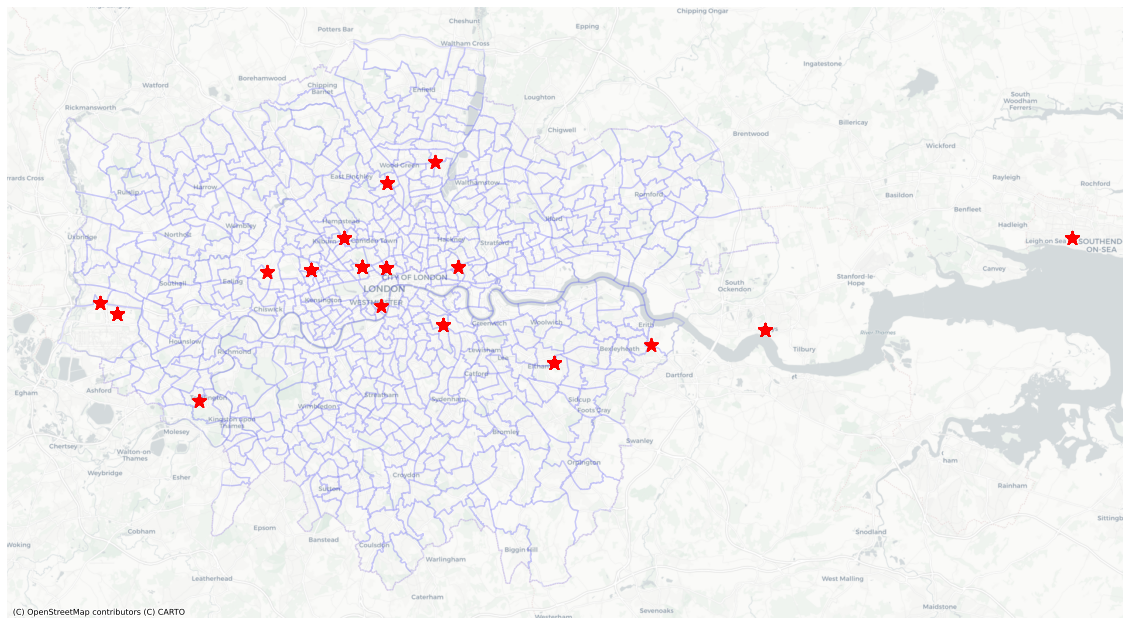

In [28]:
makeLayeredMap(london_map, gdf)